# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

<div class="alert alert-block alert-success">
<b>Up to you:</b> Use green boxes sparingly, and only for some specific 
purpose that the other boxes can't cover. For example, if you have a lot 
of related content to link to, maybe you decide to use green boxes for 
related links from each section of a notebook.
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Use blue boxes (alert-info) for tips and notes. 
If it’s a note, you don’t have to include the word “Note”.
</div>

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

#### Imports

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # yeah, sure buddy

In [13]:
import pandas as pd
import numpy as np
import sklearn as skl
import imblearn as imb

from collections import Counter

Для работы будем использовать основные метрики: `balanced_accuracy` и `f1`. У нас несбалансированная выборка (о чем можно узнать по ссылке в введении, а также в анализе датасета ниже), поэтому `accuracy` не подойдет для корректной оценки классификатора. В свою очередь `f1` укажет на ошибки I и II рода.

>`precision` и `recall` используются как второстепенные метрики, т.к. "входят" в метрику `f1`.

In [14]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, recall_score

# Просмотр результатов
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Ключевые модели: `DecisionTreeClassifier` и `RandomForestClassifier`. Еще попробуем обучить и протестировать `CatBoost`, который создан для датасета с категориальными признаками:

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.base import clone

Кросс-валидацию для поиска оптимальных параметров будем искать путем `GridSearchCV`, также настроим параметры кросс-валидации через `StratifiedKFold`:

In [16]:
from sklearn.model_selection import GridSearchCV # для поиска оптимальных гиперпараметров
from sklearn.model_selection import StratifiedKFold # для лучшего контроля кросс-валидации

from sklearn.model_selection import cross_val_score

Препроцессинг, трансформация и разбиение данных:

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

>Еще были сделаны шаги для анализа техник балансирования классов, среди них `NearMiss`, `OneSidedSelection`, `ADASYN` и другие:

In [18]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule

In [19]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN

Визуализация:

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from scikitplot.metrics import plot_roc


from sklearn import tree # для демонстрации: как устроено дерево

In [21]:
RANDOM_STATE = 42

#### Технические функции

In [22]:
target_classes = ['>50K', '<=50K']
cross_validation = StratifiedKFold(n_splits=5, shuffle=False)
grid_search_scoring = ['balanced_accuracy', 'precision', 'recall', 'f1_macro']

color_sns = 'YlOrBr'

In [23]:
def plot_confusionmatrix(y_train_pred, y_train, dom):
  """Функция строит матрицу конфузии для бинарной классификации

  Arguments:
    y_train_pred: вектор предсказанных данных на датасете размером (n_features, 1);
    y_train: вектор исходных таргет-данных на датасете размером (n_features, 1);
    dom: описание
  """

  print(f'Матрица конфузии на {dom} выборке')
  cf = confusion_matrix(y_train_pred, y_train)
  sns.heatmap(cf,
              annot=True,
              yticklabels=target_classes,
              xticklabels=target_classes,
              cmap=color_sns,
              fmt='g')
  plt.tight_layout()
  plt.show()

In [24]:
def create_plot_data(clf_gridsearch, x_col="param_n_estimators"):
  """Парсит словарь GridSearchCV в данные для графика

  Arguments:
    clft_gridsearch: обученный класс GridSearchCV
    x_col: столбец значений признака для исследования

  Returns:
    tuple object: (X, y_accuracy_score, y_f1_score) одинакового размера (index=0)
  """

  clf_pd = pd.DataFrame(clf_gridsearch.cv_results_)
  clf_pd_subdata = clf_pd[[x_col, "mean_test_balanced_accuracy", "mean_test_f1_macro"]]
  clf_pd_subdata.sort_values(by=[x_col])
  clf_pd_subdata_data = clf_pd_subdata.values.tolist()

  clf_pd_subdata_data_X = []
  clf_pd_subdata_data_Y = [[], []]

  for elem in clf_pd_subdata_data:
    clf_pd_subdata_data_X.append(elem[0])
    clf_pd_subdata_data_Y[0].append(elem[1]) #accuracy
    clf_pd_subdata_data_Y[1].append(elem[2]) #f1_score

  return(clf_pd_subdata_data_X, clf_pd_subdata_data_Y)

In [25]:
def plot_GSCV_score(grid_search, plt_label_x, plt_title, metric='f1_score', x_col="param_max_depth"):
    """Создает график изменения точности модели от изменяемых параметрах в GridSearchCV по метрике f1

    Arguments:
      grid_search: обученный класс GridSearchCV
      plt_label_x: описание для оси ординат
      plt_title: титульник графика
      metric: метрика для исследования
      x_col: столбец значений признака для исследования
    
    """

    # Выбор метрики
    if metric == 'f1_score':
        metric_idx = 1
        metric_dict = 'mean_test_f1_macro'
        metric_label = "f1 score"
    elif metric == 'balanced_accuracy':
        metric_idx = 0
        metric_dict = 'mean_test_balanced_accuracy'
        metric_label = "Balanced accuracy score"
    else:
        raise TypeError("Unknown metric")

    # Обработка значений
    (X_plot, Y_plot) = create_plot_data(grid_search, x_col)

    CI = 1.96 * np.std(Y_plot[metric_idx])/np.sqrt(len(Y_plot[metric_idx]))

    ymin = min(grid_search.cv_results_[metric_dict]) -0.1
    ymax = max(grid_search.cv_results_[metric_dict]) +0.1

    # Создание графика
    fig, ax = plt.subplots()
    
    ax.plot(X_plot, Y_plot[metric_idx], label='F1 score', color='g')
    ax.fill_between(X_plot, (Y_plot[metric_idx]-CI), (Y_plot[metric_idx]+CI), color='g', alpha=.1)

    ax.set(xlabel=plt_label_x, ylabel=metric_label, title=plt_title, ylim=(ymin, ymax))
    ax.grid()
    ax.legend()

    plt.show()

In [26]:
def plot_BalancingTests(balancer, X_train, y_train, X_val, y_val, plt_title):
    
    X_balanced, y_balanced = balancer.fit_resample(X_train, y_train)
    print(f"Распределение классов после балансировки: {sorted(Counter(y_balanced).items())}")

    ##

    param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                 }

    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=param_grid, cv=cross_validation, verbose=0, refit='balanced_accuracy', scoring=grid_search_scoring)
    grid_search.fit(X_balanced, y_balanced)

    ##

    estimator = grid_search.best_estimator_

    print(f'Train score = {f1_score(estimator.predict(X_balanced),y_balanced)}')
    print(f'Val score = {f1_score(estimator.predict(X_val),y_val)}')

    print(f"Подробный отчет:")
    print(classification_report(y_val, estimator.predict(X_val)))

    plot_GSCV_score(grid_search, plt_label_x='Параметр max_depth', plt_title=plt_title)

#### Загрузка датасета

In [27]:
dataset_pd = pd.read_csv('data_adult.csv', delimiter=',')
dataset_pd.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


Заменим в задаче бинарной классификации целевую переменную на 1 и 0:

In [28]:
target_to_replace = dataset_pd[">50K,<=50K"].unique()
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[0], value=0, inplace=True)
dataset_pd[">50K,<=50K"].replace(to_replace=target_to_replace[1], value=1, inplace=True)

In [29]:
dataset_pd.shape

(16280, 14)

In [30]:
dataset_pd.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
count,16280.000000,1.628000e+04,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,38.635074,1.894594e+05,10.098219,1020.417752,86.696314,40.403686,0.247912
std,13.635301,1.066644e+05,2.567690,6862.041550,402.308715,12.341191,0.431813
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.170068e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781340e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.371630e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [31]:
dataset_pd = dataset_pd.mask(dataset_pd == '?')
dataset_pd.dropna(inplace=True)
dataset_pd.drop_duplicates(inplace=True)
dataset_pd.shape

(15335, 14)

In [32]:
data = dataset_pd.drop(['>50K,<=50K'], axis=1)
target = dataset_pd['>50K,<=50K']

Нужно применить кодировку категориальных данных. Кодировка `ordinal encoding (OE)` подходит по смыслу только для признака `education`, но в датасете уже существует `education-num`. Так что используем по умолчанию `one-hot enconding (OHE)`.

In [33]:
dataset_pd.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,0
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,0
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,0
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,0
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,1


In [34]:
# Категориальные: 
cat_cols = ["workclass",
            "education",
            "marital-status",
            "occupation",
            "relationship",
            "race",
            "sex",
            ]

# Числовые:
num_cols = ["age",
            "fnlwgt",
            "education-num",
            "capital-gain",
            "capital-loss",
            "hours-per-week"]

for feature_val in cat_cols:
    print(f"{feature_val}: \t{dataset_pd[feature_val].unique()}\n")

workclass: 	['Local-gov' 'Private' 'Federal-gov' 'Self-emp-inc' 'State-gov'
 'Self-emp-not-inc' 'Without-pay']

education: 	['HS-grad' 'Some-college' 'Bachelors' 'Assoc-acdm' '12th' 'Doctorate'
 '1st-4th' '7th-8th' 'Masters' '5th-6th' '11th' '9th' 'Assoc-voc'
 'Prof-school' '10th' 'Preschool']

marital-status: 	['Never-married' 'Divorced' 'Married-civ-spouse' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse' 'Widowed']

occupation: 	['Farming-fishing' 'Sales' 'Prof-specialty' 'Tech-support' 'Adm-clerical'
 'Other-service' 'Machine-op-inspct' 'Protective-serv' 'Transport-moving'
 'Exec-managerial' 'Craft-repair' 'Handlers-cleaners' 'Priv-house-serv'
 'Armed-Forces']

relationship: 	['Not-in-family' 'Own-child' 'Husband' 'Unmarried' 'Wife' 'Other-relative']

race: 	['Black' 'White' 'Amer-Indian-Eskimo' 'Asian-Pac-Islander' 'Other']

sex: 	['Male' 'Female']



При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

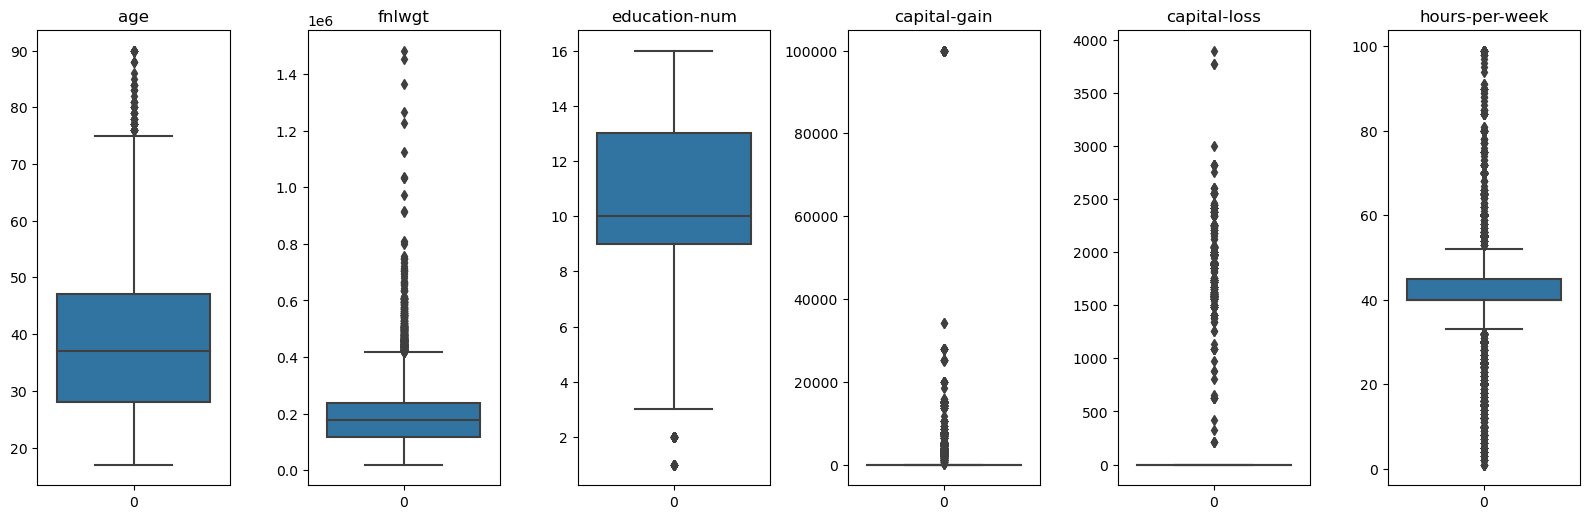

In [35]:
# Категориальные данные
plt.figure(figsize=(16,10))
for i,col in enumerate(num_cols):    
    plt.subplot(2,6,i + 1)
    ax = sns.boxplot(data=data[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()

Важное замечание: `sns.boxplot` отмечает выбросы данных как черный ромб. Это выбросы по определению, совсем не значит, что от них стоит избавляться. Но по определению $IQR$ можно сделать вывод, что в выборке очень много людей с нулевым значением признаков `capital-gain` и `capital-loss`. Информация о датасете довольно поверхностная, поэтому я не могу сделать вывод что делать с этими признаками. Оставляем.

In [36]:
# Численные данные
num_all = data.shape[0]

for i, col in enumerate(cat_cols):
    print(data[col].value_counts(normalize=True))
    print('\n')

workclass
Private             0.734920
Self-emp-not-inc    0.086338
Local-gov           0.069579
State-gov           0.042061
Self-emp-inc        0.036583
Federal-gov         0.030062
Without-pay         0.000456
Name: proportion, dtype: float64


education
HS-grad         0.322726
Some-college    0.220802
Bachelors       0.168569
Masters         0.055950
Assoc-voc       0.045321
11th            0.034170
Assoc-acdm      0.033192
10th            0.026541
Prof-school     0.018911
7th-8th         0.018846
9th             0.015194
Doctorate       0.012520
12th            0.012129
5th-6th         0.009260
1st-4th         0.004304
Preschool       0.001565
Name: proportion, dtype: float64


marital-status
Married-civ-spouse       0.471992
Never-married            0.319661
Divorced                 0.135507
Separated                0.032279
Widowed                  0.027519
Married-spouse-absent    0.012390
Married-AF-spouse        0.000652
Name: proportion, dtype: float64


occupation
Prof-spe

Не будем убирать выбросы данных, хотя хорошие кандидаты неа удаление это объекты с признаком `education: {"Preschool", "1st-4th", "5th-6th"}`. Логично предположить, что для таких людей целевая переменная должна быть `<50`, иначе же такой объект - явно выброс. 

In [37]:
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))

{0: 11396, 1: 3939}

Обнаружен дисбаланс классов. Будем его как-то балансировать, с помощью методов [здесь](#balancing_classes)

## Трансформация данных



In [38]:
dataset_pd.columns.to_list()

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 '>50K,<=50K']

In [39]:
columns_to_scale  = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] #[0, 1, 2, 3, 4, 5]
columns_to_encode = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

### Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [40]:
ohe = skl.preprocessing.OneHotEncoder()

encoded_cols = ohe.fit_transform(data[columns_to_encode]).toarray()

In [41]:
print(f"Размер матрицы признаков до OHE: {data[columns_to_encode].shape[1]}   \nРазмер матрицы признаков после OHE: {encoded_cols.shape[1]}")

Размер матрицы признаков до OHE: 7   
Размер матрицы признаков после OHE: 57


### Скейлинг и конкатенация трансформированных участков датасета

Скейлинг данных это проекция непрерывных величин на какой-то другой интервал путем, например, следующего преобразования: $$x' = \frac{x-\mu}{\sigma}$$ 

В случае с категориальными данными скейлинг не допустим, т.к. даже после кодировки, в признаке остаются дискретные значения. 

Будем использовать `StandartScaler`, т.к. найденные выбросы данных (согласно `boxplot`) не являются таковыми. Как альтернатива можно использовать `RobustScaler`.


In [42]:
scaler = StandardScaler()

scaled_cols = scaler.fit_transform(data[columns_to_scale])

In [43]:
data_processed = np.concatenate([scaled_cols, encoded_cols], axis=1)

print(f"Размер матрицы признаков до трансформации: {data.shape} = {data[columns_to_scale].shape} + {data[columns_to_encode].shape}")
print(f"Размер матрицы признаков после трансформации: {data_processed.shape} = {scaled_cols.shape} + {encoded_cols.shape}")

Размер матрицы признаков до трансформации: (15335, 13) = (15335, 6) + (15335, 7)
Размер матрицы признаков после трансформации: (15335, 63) = (15335, 6) + (15335, 57)


Выделим из `X_train` датасет для валидации, не трогая `X_test`

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, target, train_size=0.6, random_state=RANDOM_STATE) # Train/Test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, random_state=RANDOM_STATE) # Train/Val split
print(f"Train dataset: {X_train.shape, y_train.shape}; \nValidation dataset: {X_val.shape, y_val.shape}; \nTest dataset: {X_test.shape, y_test.shape}")

Train dataset: ((6440, 63), (6440,)); 
Validation dataset: ((2761, 63), (2761,)); 
Test dataset: ((6134, 63), (6134,))


### Исследование способов балансирования классов

<a id='balancing_classes'></a>

В __[источнике датасета](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)__ указано, что присутствует дисбаланс классов: $\approx 25\% /75\%$ (что мы и наблюдаем выше). Назовем редковстречающийся класс *негативным*, а другой - *позитивным* и попробуем решить эту проблему следующими методами:

* Oversampling: дублирование редковстречающихся таргетов;
* Undersampling: удаление частовстречающихся таргетов;
* Weighted sampling: добавление веса к таргетам в процессе обучения моделей.

Будем проверять методы на Решающем дереве - очень чувствительной к дисбалансу классов модели. В качестве метрики будем использовать f1_score по той же причине.

In [45]:
print(f"Распределение классов в train датасете до балансировки: {sorted(Counter(y_train).items())}")

Распределение классов в train датасете до балансировки: [(0, 4759), (1, 1681)]


#### Undersampling

Этот способ все таки приведет к серьезной потере данных, однако стоит попробовать сравнить эти техники. Начнем со стандартного `RandomUnderSampler`, который случайным образом удаляет позитивный класс, пока количество этого класса не сравняется с количеством далее - негативного класса:


Распределение классов после балансировки: [(0, 2401), (1, 1681)]
Train score = 0.7854785478547854
Val score = 0.6877076411960132
Подробный отчет:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2007
           1       0.59      0.82      0.69       754

    accuracy                           0.80      2761
   macro avg       0.76      0.80      0.77      2761
weighted avg       0.83      0.80      0.80      2761



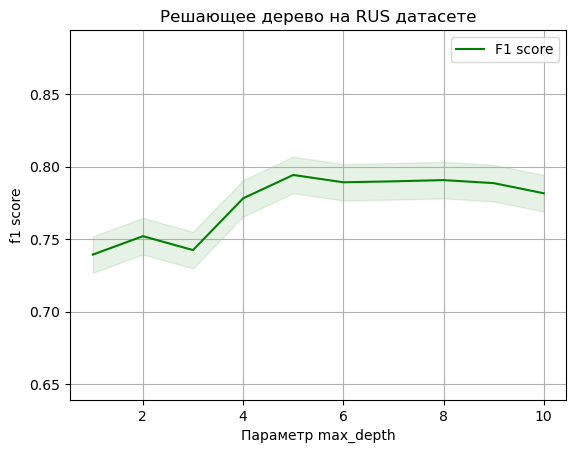

In [46]:
rus = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=0.7)

plot_BalancingTests(rus, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на RUS датасете")

`RandomUnderSampler` показал хороший результат, но мы можем попробовать улучшить его, используя алгоритмы на основе `kNN`, как например `NearMiss`. К сожалению, __[`NearMiss-3 работает не всегда так, как задумано`](https://github.com/scikit-learn-contrib/imbalanced-learn/issues/836)__, поэтому будем использовать `NearMiss-2`, т.к. он __[более устойчив](https://imbalanced-learn.org/stable/under_sampling.html#mathematical-formulation)__ к шуму в данных:

Распределение классов после балансировки: [(0, 2401), (1, 1681)]
Train score = 0.6576704545454545
Val score = 0.6325301204819278
Подробный отчет:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      2007
           1       0.73      0.56      0.63       754

    accuracy                           0.82      2761
   macro avg       0.79      0.74      0.76      2761
weighted avg       0.82      0.82      0.82      2761



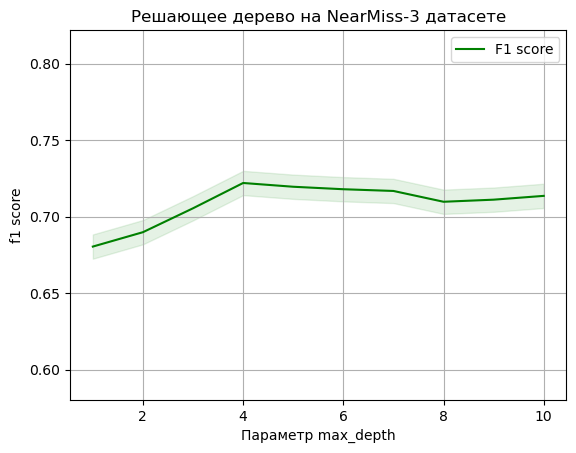

In [47]:
nms3 = NearMiss(version=2, sampling_strategy=0.7)

plot_BalancingTests(nms3, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на NearMiss-3 датасете")

Результат стал хуже из-за зашумленности данных. В этом контексте шумом можно назвать стандартные данные, которые слишком просто классифицировать. Согласно __[методам по очистке данных IBLearn](https://imbalanced-learn.org/stable/under_sampling.html#cleaning-under-sampling-techniques)__, существует несколько способов, основанных на `kNN` и `Tomek Links`, для умной балансировки данных. Рассмотрим два :`OneSidedSelection` и `Neighborhood Cleaning Rule`. Второй метод отличается тем, что вместо прямого (хоть и умного) удаления данных, данные проходят "очистку" от некачественных объектов.

`OneSidedSelection` действует по следующему принципу:

Пусть: 
    
* Множество $A$ - исходная train-выборка;
* Множество $B$ содержит все `1`-классы (позитивные) и $!$ `0`-класс (негативный). $B$ постоянен относительно $A$, т.е.:

$$B \subseteq A \text{ и обученный на $B$ классификатор 1NN верно предсказывает $\forall a \in A$}$$

Алгоритм:

* 1-NN классификатор обучается на $B$;
* 1-NN предсказывает точки на $A$. Т.к. $B$ постоянен к $A$, нас будут интересовать точки $x \in A \setminus B $;
* Неверно классифицированные точки на $A$ добавляются в множество $B$;
* Из $C$ убираются все т.н. Tomek links.

Распределение классов после балансировки: [(0, 4405), (1, 1681)]
Train score = 0.7630121816168328
Val score = 0.6921697549312612
Подробный отчет:
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2007
           1       0.63      0.77      0.69       754

    accuracy                           0.81      2761
   macro avg       0.77      0.80      0.78      2761
weighted avg       0.83      0.81      0.82      2761



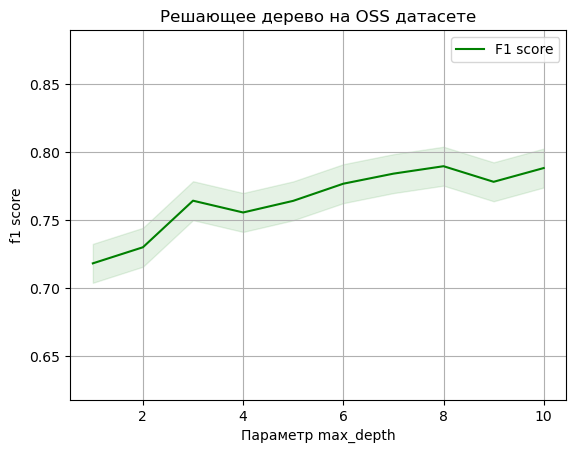

In [48]:
oss = OneSidedSelection(random_state=RANDOM_STATE)

plot_BalancingTests(oss, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на OSS датасете")

Эффективность такой балансировки намного лучше, чем `NearMiss-3`, но `OSS` все еще может страдать от шумных данных. Опробуем `Neighborhood Cleaning Rule`, который действует по следующему принципу: 

Пусть: 
    
* Множество $A$ - исходная train-выборка;
* Множество $B$ содержит все `1`-классы (позитивные). $B$ постоянен относительно $A$;

Алгоритм:

* Согласно классификатору `ENN` создается множество $\sigma_1 \in A$. Этот шаг выделяет зашумленные данные в $A$;
* Аналогично отбираются данные внутри множества $B$: если `3-NN` неверно классифицирует объект $\in B$ на $A$. Отобранные объекты формируют множество $\sigma_2$;
* Результирующий датасет: $\overline{A} = A - (\sigma_1 \cup \sigma_2)$


Распределение классов после балансировки: [(0, 3531), (1, 1681)]
Train score = 0.8665676077265972
Val score = 0.6864501679731242
Подробный отчет:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2007
           1       0.59      0.81      0.69       754

    accuracy                           0.80      2761
   macro avg       0.76      0.80      0.77      2761
weighted avg       0.83      0.80      0.81      2761



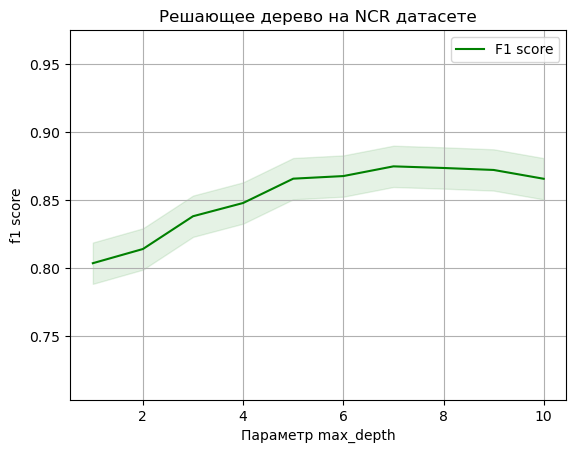

In [49]:
ncr = NeighbourhoodCleaningRule()

plot_BalancingTests(ncr, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на NCR датасете")

В итоге с помощью `Neighborhood Cleaning Rule` мы сравнялись по `f1`-метрике на валидационной выборке к `RandomUnderSampler`, при этом обогнали на train-выборке. Среди всех техник under-сэмплинга будем использовать `Neighborhood Cleaning Rule`.

#### Oversampling

Существует несколько способов наращивать количество негативного класса, начнем со стандартного случайного дублирования (`RandomOverSampler`):

Распределение классов после балансировки: [(0, 4759), (1, 4759)]


Train score = 0.8851430811446492
Val score = 0.6825827455236029
Подробный отчет:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2007
           1       0.58      0.83      0.68       754

    accuracy                           0.79      2761
   macro avg       0.75      0.80      0.76      2761
weighted avg       0.83      0.79      0.80      2761



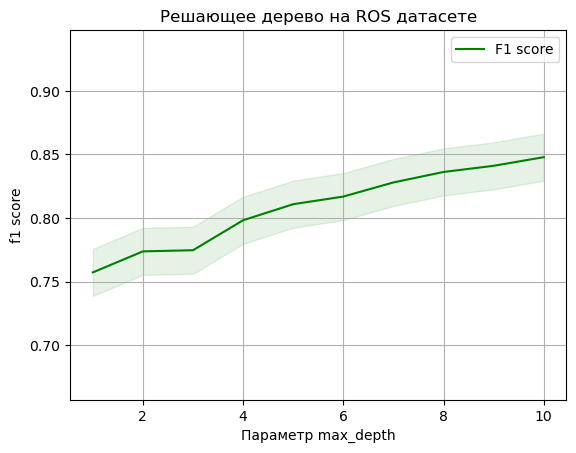

In [50]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

plot_BalancingTests(ros, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на ROS датасете")

Уже лучше, чем большинство техник under-сэмплирования. Попробуем `SMOTE` и `ADASYN`, которые генерируют новые данные, а не дублируют их. __[Согласно документации](https://imbalanced-learn.org/stable/over_sampling.html#ill-posed-examples)__, `SMOTE` равномерно "заселяет" спорные участки датасета, а `ADASYN` интерполирует их, согласно ошибкам k ближайших соседей.

Распределение классов после балансировки: [(0, 4759), (1, 4759)]
Train score = 0.8978234582829504
Val score = 0.6666666666666667
Подробный отчет:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2007
           1       0.59      0.76      0.67       754

    accuracy                           0.79      2761
   macro avg       0.75      0.78      0.76      2761
weighted avg       0.82      0.79      0.80      2761



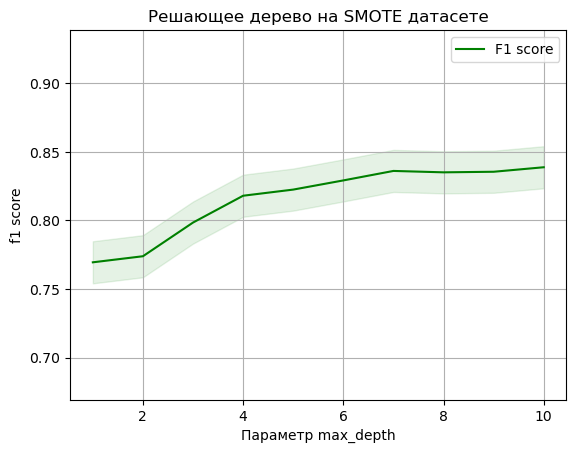

In [51]:
smote = SMOTE(random_state=RANDOM_STATE)

plot_BalancingTests(smote, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на SMOTE датасете")

Распределение классов после балансировки: [(0, 4759), (1, 4855)]
Train score = 0.8864419762543088
Val score = 0.6706135629709365
Подробный отчет:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      2007
           1       0.56      0.83      0.67       754

    accuracy                           0.78      2761
   macro avg       0.74      0.79      0.75      2761
weighted avg       0.82      0.78      0.79      2761



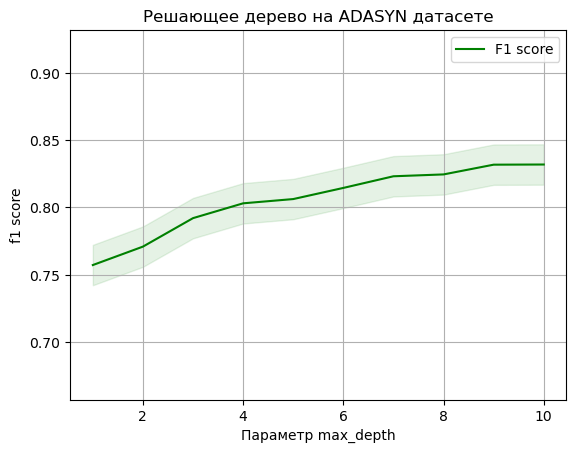

In [52]:
adasyn = ADASYN(random_state=RANDOM_STATE)

plot_BalancingTests(adasyn, X_train, y_train, X_val, y_val, plt_title="Решающее дерево на ADASYN датасете")

Среди всех методов over-сэмплинга остановимся на `ADASYN`, который похож скором на `NeighbourhoodCleaningRule`, но совершает немного больше ошибок и синтезирует (возможно некорректные с точки зрения датасета) данные.

#### Weighted fit

Этот способ позволяет сбалансировать классы, добавив веса к классам при обучении классификатора.

In [53]:
smpl_weights = y_train.copy().astype(float)
weight = 0.6
smpl_weights[smpl_weights == 1] = weight
smpl_weights[smpl_weights == 0] = 1-weight

Train score = 0.6901373283395755
Val score = 0.6843317972350231
Подробный отчет:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      2007
           1       0.60      0.79      0.68       754

    accuracy                           0.80      2761
   macro avg       0.76      0.80      0.77      2761
weighted avg       0.83      0.80      0.81      2761



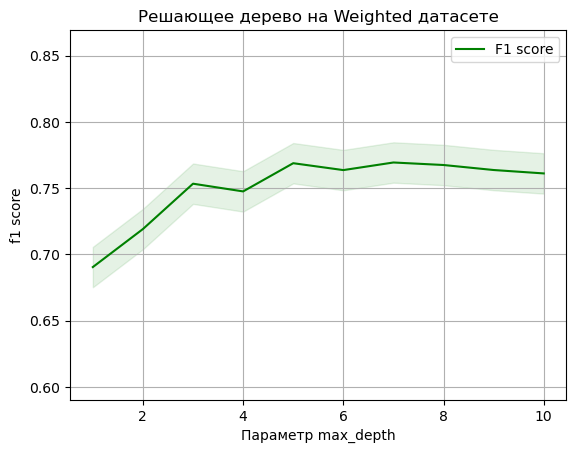

In [54]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=param_grid, cv=cross_validation, verbose=0, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search.fit(X_train, y_train, sample_weight=smpl_weights)

estimator = grid_search.best_estimator_
print(f'Train score = {f1_score(estimator.predict(X_train), y_train)}')
print(f'Val score = {f1_score(estimator.predict(X_val),y_val)}')

print(f"Подробный отчет:")
print(classification_report(y_val, estimator.predict(X_val)))
plot_GSCV_score(grid_search, plt_label_x='Параметр max_depth', plt_title='Решающее дерево на Weighted датасете')

___

В итоге будем использовать under-сэмплинг методом `NeighbourhoodCleaningRule`, т.к. он не синтезирует новые данные и сохраняет балансировку не путем удаления данных из позитивного класса, а избавлением от шумов:

In [55]:
X_train, y_train = ncr.fit_resample(X_train, y_train)

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

Доверительный интервал $CI$ посчитаем самостоятельно по следующей формуле: $$CI = \overline x \pm z \frac{\sigma}{\sqrt{n}},$$

где
* $\overline{x} = \frac{x_1 + \dots + x_n}{n};$
* $z$ - значение доверительного интервала: условимся, что $z=1.96$, что соответствует $95\%;$
* $\sigma$ - стандартное отклонение точек;
* $n$ - количество точек.

### Простой GridSearchCV

Для начала обучим  выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).
 
Остальные параметры оставляйте в значениях по умолчанию.

#### Решающее дерево

In [56]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #без None
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_1 = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [57]:
dt_basic = grid_search_dt_1.best_estimator_

Лучший balanced_accuracy_score: 0.8737593924329442


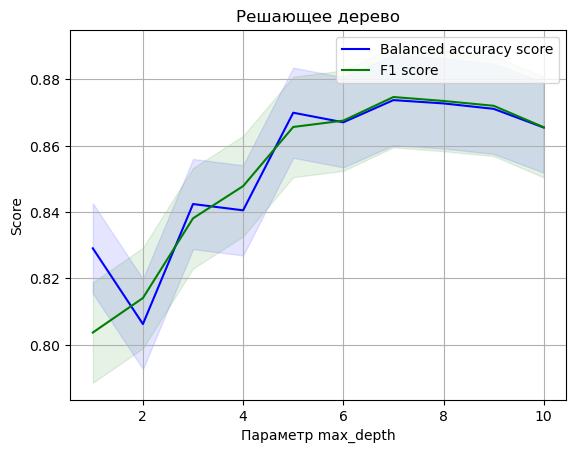

In [58]:
print(f"Лучший balanced_accuracy_score: {grid_search_dt_1.best_score_}")

(X_plot, Y_plot) = create_plot_data(grid_search_dt_1, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Решающее дерево')
ax.grid()
ax.legend()

plt.show()

In [59]:
# Попробуем посмотреть прунинг на дереве с max_depth=None

dt_basic_pruned = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None).fit(X_train, y_train)
path = dt_basic.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [60]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = clone(dt_basic)
    clf.set_params(ccp_alpha=ccp_alpha, max_depth=None, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [61]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

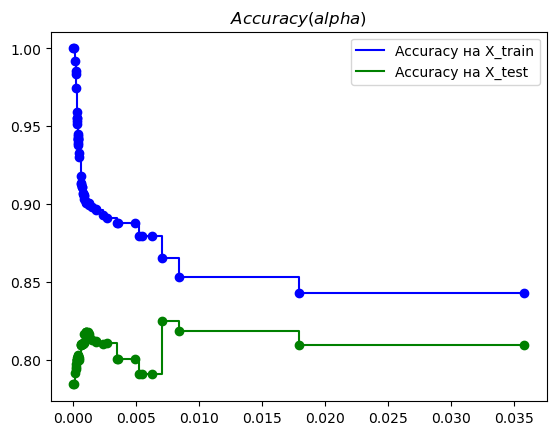

In [62]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(c.predict(X_train),y_train))
    test_acc.append(accuracy_score(c.predict(X_test),y_test))

plt.scatter(ccp_alphas,train_acc, color='b')
plt.scatter(ccp_alphas,test_acc, color='g')
plt.plot(ccp_alphas,train_acc,label='Accuracy на X_train',drawstyle="steps-post", color='b')
plt.plot(ccp_alphas,test_acc,label='Accuracy на X_test',drawstyle="steps-post", color='g')
plt.legend()
plt.title('$Accuracy(alpha)$')
plt.show()

In [63]:
ccp_alpha_hand_picked = 0.008
dt_basic_pruned=clone(dt_basic)
dt_basic_pruned.set_params(ccp_alpha=ccp_alpha_hand_picked, max_depth=None, random_state=RANDOM_STATE)

dt_basic_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.008, random_state=42)

In [64]:

for estimator in {dt_basic, dt_basic_pruned}:
    if (estimator.get_params()['ccp_alpha'] == 0.0):
        print(f"Estimator: non-pruned {estimator.__class__.__name__}")
    else:
        print(f"Estimator: pruned {estimator.__class__.__name__}")
    num = 3
    print(f"Accuracy: \t{round(accuracy_score(y_test, estimator.predict(X_test)), num)}")
    print(f"Precision: \t{round(precision_score(y_test, estimator.predict(X_test)), num)}")
    print(f"Recall: \t{round(recall_score(y_test, estimator.predict(X_test)), num)}")
    print(f"f1 score: \t{round(f1_score(y_test, estimator.predict(X_test)), num)}")

Estimator: pruned DecisionTreeClassifier
Accuracy: 	0.825
Precision: 	0.627
Recall: 	0.707
f1 score: 	0.665
Estimator: non-pruned DecisionTreeClassifier
Accuracy: 	0.803
Precision: 	0.568
Recall: 	0.824
f1 score: 	0.672


Как мы видим, прунинг не сильно помог в улучшении оценки Решающего Дерева, т.к. мы вручную исключили параметр `max_depth=None` (оставили только целочисленные значения).

#### Случайный лес

In [65]:
param_grid = {'max_depth' : [1, 2, 4, 6, 8, 10, 12, 14, 16] #без None
             }

estimator = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search_rf_1 = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_rf_1.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [66]:
rf_basic = grid_search_rf_1.best_estimator_

Лучший balanced_accuracy_score: 0.8886592558755652


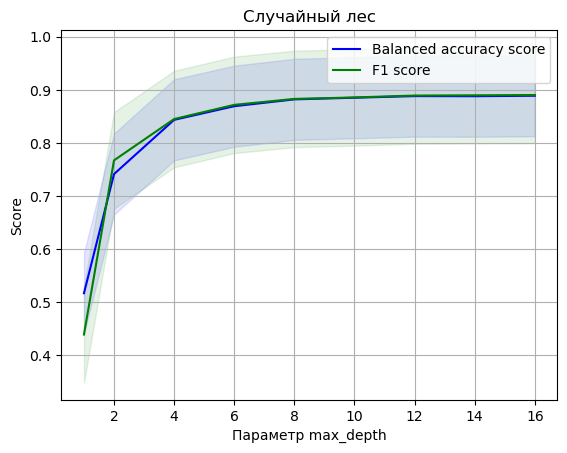

In [67]:
print(f"Лучший balanced_accuracy_score: {grid_search_rf_1.best_score_}")
(X_plot, Y_plot) = create_plot_data(grid_search_rf_1, x_col="param_max_depth")

fig, ax = plt.subplots()

CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр max_depth', ylabel='Score',
       title='Случайный лес')
ax.grid()
ax.legend()

plt.show()

### Комплексный GridSearchCV

Далее произведем подбор других гиперпараметров алгоритмов. Начнет со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

#### Случайный лес

In [68]:
# Я не очень понял что требуется в задании выше, поэтому подобрал `n_estimators` через обычный GridSearchCV
param_grid = {'n_estimators' : [1, 10, 30, 50, 70, 100] #без None
             }

estimator = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search_rf_2_test = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_rf_2_test.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'n_estimators': [1, 10, 30, 50, 70, 100]},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

Лучший balanced_accuracy_score: 0.8892819993054669


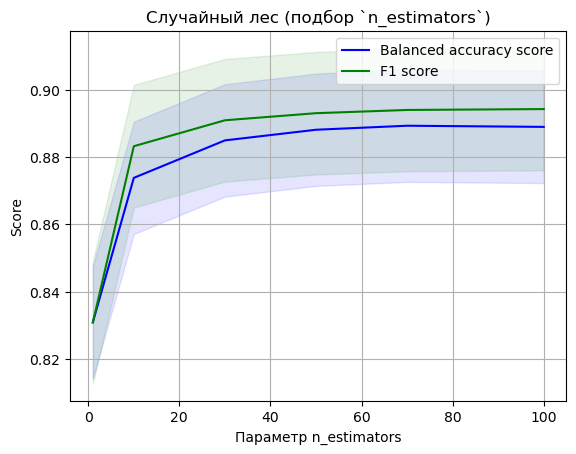

In [69]:
print(f"Лучший balanced_accuracy_score: {grid_search_rf_2_test.best_score_}")
(X_plot, Y_plot) = create_plot_data(grid_search_rf_2_test, x_col="param_n_estimators")

fig, ax = plt.subplots()
CI = 1.96 * np.std(Y_plot[0])/np.sqrt(len(Y_plot[0]))
ax.plot(X_plot, Y_plot[0], label='Balanced accuracy score', color='b')
ax.fill_between(X_plot, (Y_plot[0]-CI), (Y_plot[0]+CI), color='b', alpha=.1)

CI = 1.96 * np.std(Y_plot[1])/np.sqrt(len(Y_plot[1]))
ax.plot(X_plot, Y_plot[1], label='F1 score', color='g')
ax.fill_between(X_plot, (Y_plot[1]-CI), (Y_plot[1]+CI), color='g', alpha=.1)

ax.set(xlabel='Параметр n_estimators', ylabel='Score',
       title='Случайный лес (подбор `n_estimators`)')
ax.grid()
ax.legend()

plt.show()

Из графика видно, что при `n_estimators = 50` score Случайного леса выходит на плато.

Теперь подберите следующие оптимальные параметры:
- максимальная глубина решающего дерева (*max_depth*)
- функция оценки качества разбиения (*criterion*)
- максимальное количесво учитываемых признаков при разбиении (*max_features*)

Остальные параметры оставляйте по умолчанию, за исключением парамтра `n_estimators` для случайного леса, выбранного на предыдущем шаге.

In [70]:
param_grid = {'max_depth' : [1, 2, 4, 6, 8, 10, 12, 14, 16],
              'criterion' : ["gini", "entropy", "log_loss"],
              'max_features' : ["sqrt", "log2"],
             }

estimator = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50)
grid_search_rf_2 = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_rf_2.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_cl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(n_estimators=50, random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 4, 6, 8, 10, 12, 14, 16],
                         'max_features': ['sqrt', 'log2']},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [71]:
rf_better = grid_search_rf_2.best_estimator_

#### Решающее дерево

In [72]:
param_grid = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'criterion' : ["gini", "entropy", "log_loss"],
              'max_features' : ["sqrt", "log2"],
             }

estimator = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search_dt_2 = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cross_validation, verbose=1, refit='balanced_accuracy', scoring=grid_search_scoring)
grid_search_dt_2.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_cl

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\sklearn\metrics\_cl

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['sqrt', 'log2']},
             refit='balanced_accuracy',
             scoring=['balanced_accuracy', 'precision', 'recall', 'f1_macro'],
             verbose=1)

In [73]:
dt_better = grid_search_dt_2.best_estimator_

#### Оценка скорости обучения



Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

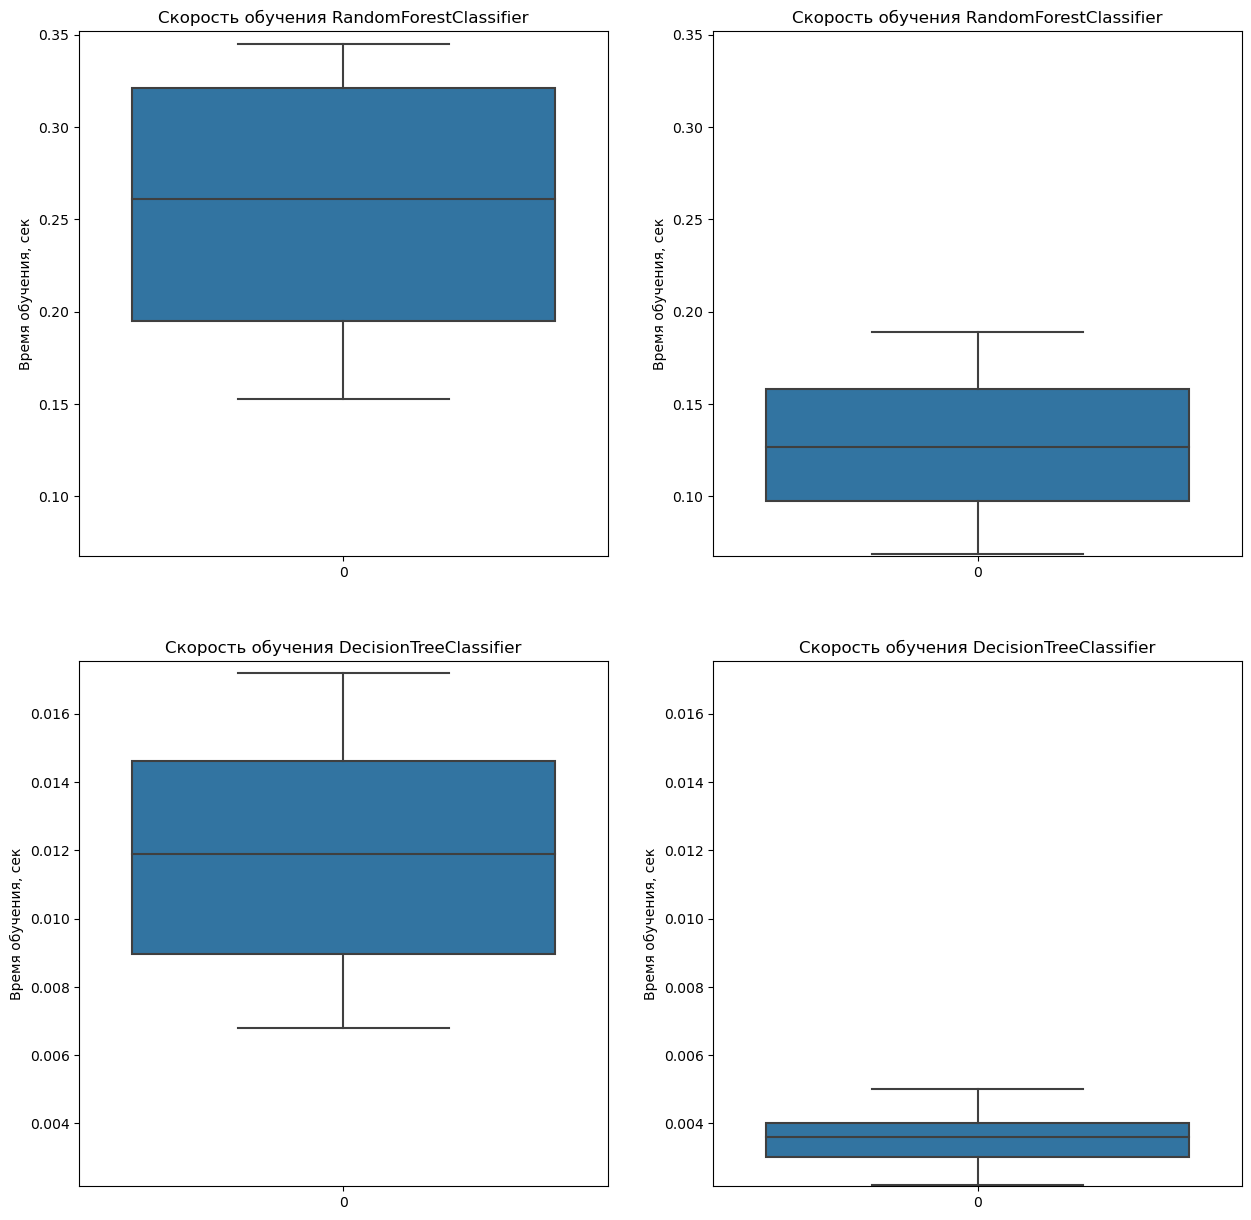

In [74]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

pairs = {(grid_search_dt_1, grid_search_dt_2), (grid_search_rf_1, grid_search_rf_2)}

for GSCV in pairs:
    mft_1 = GSCV[0].cv_results_["mean_fit_time"]
    mft_2 = GSCV[1].cv_results_["mean_fit_time"]

    # Для читаемости
    min = np.min(mft_1) if (np.min(mft_2) > np.min(mft_1)) else np.min(mft_2)
    max = np.max(mft_1) if (np.max(mft_2) < np.max(mft_1)) else np.max(mft_2)
    mul = 1.02
    min /= mul
    max *= mul

    sns.boxplot(data=mft_1, ax=ax[i, 0])
    ax[i, 0].set_title("Скорость обучения "+str(GSCV[0].best_estimator_.__class__.__name__))
    ax[i, 0].set_ylabel("Время обучения, сек")
    ax[i, 0].set(ylim=(min, max))

    sns.boxplot(data=mft_2, ax=ax[i, 1])
    ax[i, 1].set_title("Скорость обучения "+str(GSCV[1].best_estimator_.__class__.__name__))
    ax[i, 1].set_ylabel("Время обучения, сек")
    ax[i, 1].set(ylim=(min, max))

    i+=1

## Сравнение результатов

Сравните результаты алгоритмво. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

#### DecisionTree и RandomForest

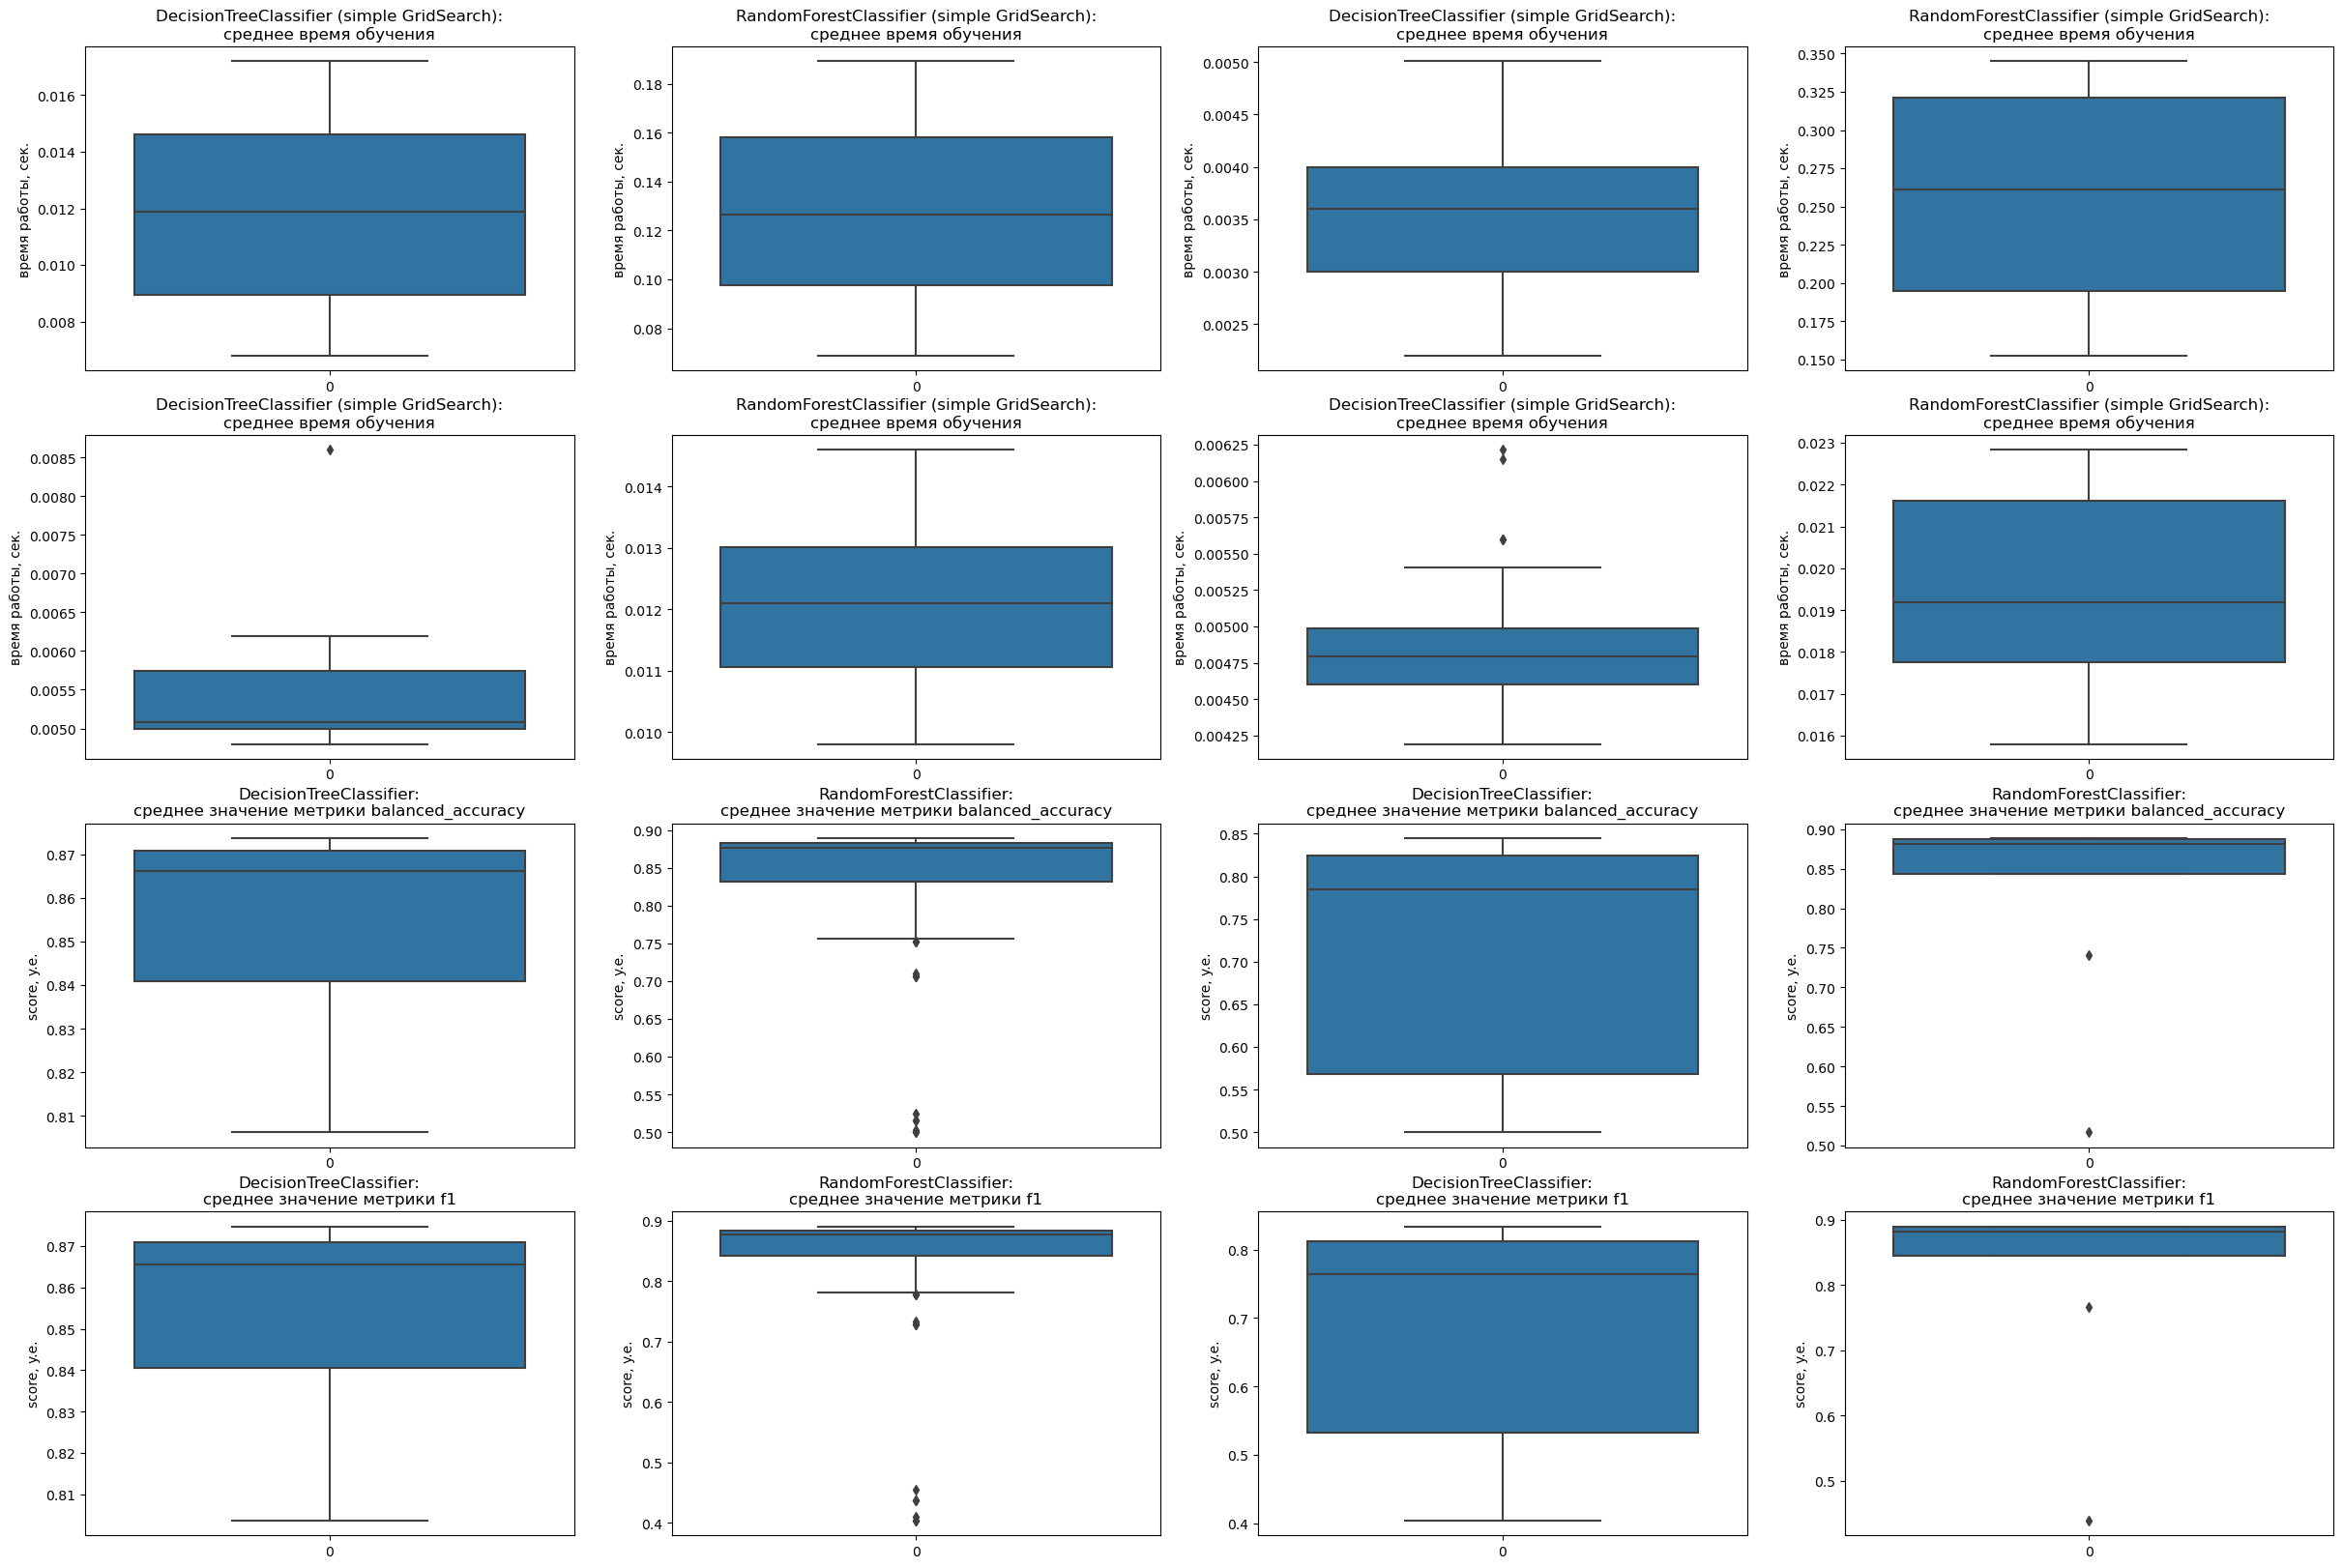

In [92]:
fig, ax = plt.subplots(4, 4)
fig.set_figheight(20)
fig.set_figwidth(30)
i = 0

for GSCV in {grid_search_dt_1, grid_search_dt_2, grid_search_rf_1, grid_search_rf_2}:
    mft = GSCV.cv_results_["mean_fit_time"]
    mst = GSCV.cv_results_["mean_score_time"]
    mt_acc = GSCV.cv_results_["mean_test_balanced_accuracy"]
    mt_f1 = GSCV.cv_results_["mean_test_f1_macro"]

    sns.boxplot(data=mft, ax=ax[0, i])
    if (len(GSCV.cv_results_['mean_fit_time'])):
        title = f"{str(GSCV.best_estimator_.__class__.__name__)} (simple GridSearch):\nсреднее время обучения"
    else:
        title = f"{str(GSCV.best_estimator_.__class__.__name__)} (complex GridSearch):\nсреднее время обучения"
    ax[0, i].set_title(title)
    ax[0, i].set_ylabel("время работы, сек.")

    sns.boxplot(data=mst, ax=ax[1, i])
    ax[1, i].set_title(title)
    ax[1, i].set_ylabel("время работы, сек.")

    sns.boxplot(data=mt_acc, ax=ax[2, i])
    ax[2, i].set_title(f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее значение метрики balanced_accuracy")
    ax[2, i].set_ylabel("score, y.e.")

    sns.boxplot(data=mt_f1, ax=ax[3, i])
    ax[3, i].set_title(f"{str(GSCV.best_estimator_.__class__.__name__)}:\nсреднее значение метрики f1")
    ax[3, i].set_ylabel("score, y.e.")

    i+=1

В итоге получаем на кросс валидации следующие результаты: `DecisionTreeClassifier`, который хотя и намного проще `RandomForestClassifier`, обучался гораздо быстрее и по метрике `balanced_accuracy` также эффективнее. Но стоит заметить, что одинокое дерево часто ошибается, согласно `f1_score`, нежели ансамбль. 

Рассмотрим подробно какие гиперпараметры попали в интервал $$value \in (Q_1; Q_1-1.5\times IQR)$$

где:
* $IQR = Q_3 - Q_1$ - Межквартильный размах;
* $Q_1$ - первый квартиль;
* $Q_3$ - третий квартиль.

In [87]:
for i, GSCV in enumerate({grid_search_dt_1, grid_search_dt_2}):
    mt_f1 = GSCV.cv_results_["mean_test_f1_macro"]

    q1 = np.quantile(mt_f1, 0.25)
    q3 = np.quantile(mt_f1, 0.75)
    iqr = q3-q1
    lower_b = q1-(1.5*iqr)
    upper_b = q3+(1.5*iqr)
    values = list(mt_f1)

    # Считаем выбросы
    outlier_arr = []
    if i == 1:
        print(f"Параметры моделей 'Простой GridSearchCV' {str(GSCV.best_estimator_.__class__.__name__)}, для которых значение метрики меньше Q_1:")
    else:
        print(f"Параметры моделей 'Комплексный GridSearchCV' {str(GSCV.best_estimator_.__class__.__name__)}, для которых значение метрики меньше Q_1:")

    for elem in values:
        if elem >= lower_b and elem < q1:
            outlier_arr.append(values.index(elem))

    for idx in outlier_arr:
        print(GSCV.cv_results_['params'][idx])

    print("\n")
    

Параметры моделей 'Комплексный GridSearchCV' DecisionTreeClassifier, для которых значение метрики меньше Q_1:
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
{'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2'}
{'criterion': 'gini', 

Закономерный вывод: максимальная глубина дерева сильно влияет на качество предсказания модели. С другой стороны, большая глубина может перейти в `max_depth: None`, когда дерево гарантированно переобучается и необходим прунинг.

#### CatBoost

Существует еще одна модель, которая хорошо работает с категориальными признаками: `CatBoostClassifier` Яндекса. Обучим его по стандартным параметрам, но на датасете без `one-hot` кодирования и `SMOTE` балансировки:

In [264]:
#cat_cols_id = [1, 3, 5, 6, 7, 8, 9]
cb_basic=CatBoostClassifier().fit(X_train, y_train)#, cat_cols_id)

Learning rate set to 0.031477
0:	learn: 0.6692801	total: 6.83ms	remaining: 6.82s
1:	learn: 0.6449712	total: 12.2ms	remaining: 6.11s
2:	learn: 0.6230241	total: 17.9ms	remaining: 5.93s
3:	learn: 0.5994569	total: 23.1ms	remaining: 5.75s
4:	learn: 0.5792472	total: 28.4ms	remaining: 5.65s
5:	learn: 0.5600469	total: 33.9ms	remaining: 5.62s
6:	learn: 0.5438383	total: 39ms	remaining: 5.54s
7:	learn: 0.5308908	total: 44.3ms	remaining: 5.49s
8:	learn: 0.5161428	total: 49.6ms	remaining: 5.46s
9:	learn: 0.5039045	total: 55.3ms	remaining: 5.47s
10:	learn: 0.4934598	total: 60.8ms	remaining: 5.46s
11:	learn: 0.4826070	total: 66.4ms	remaining: 5.46s
12:	learn: 0.4719051	total: 71.7ms	remaining: 5.44s
13:	learn: 0.4633882	total: 77.1ms	remaining: 5.43s
14:	learn: 0.4553458	total: 82.7ms	remaining: 5.43s
15:	learn: 0.4457278	total: 87.9ms	remaining: 5.41s
16:	learn: 0.4387905	total: 93.3ms	remaining: 5.4s
17:	learn: 0.4309824	total: 98.7ms	remaining: 5.39s
18:	learn: 0.4241308	total: 104ms	remaining: 5.

131:	learn: 0.2644078	total: 714ms	remaining: 4.7s
132:	learn: 0.2640377	total: 720ms	remaining: 4.69s
133:	learn: 0.2636812	total: 726ms	remaining: 4.69s
134:	learn: 0.2633738	total: 732ms	remaining: 4.69s
135:	learn: 0.2630937	total: 738ms	remaining: 4.69s
136:	learn: 0.2627253	total: 743ms	remaining: 4.68s
137:	learn: 0.2624857	total: 748ms	remaining: 4.67s
138:	learn: 0.2621717	total: 754ms	remaining: 4.67s
139:	learn: 0.2618434	total: 759ms	remaining: 4.66s
140:	learn: 0.2614344	total: 764ms	remaining: 4.65s
141:	learn: 0.2611537	total: 769ms	remaining: 4.65s
142:	learn: 0.2609319	total: 774ms	remaining: 4.64s
143:	learn: 0.2606295	total: 779ms	remaining: 4.63s
144:	learn: 0.2603930	total: 784ms	remaining: 4.62s
145:	learn: 0.2601214	total: 790ms	remaining: 4.62s
146:	learn: 0.2598956	total: 795ms	remaining: 4.61s
147:	learn: 0.2596787	total: 800ms	remaining: 4.6s
148:	learn: 0.2594522	total: 805ms	remaining: 4.6s
149:	learn: 0.2591414	total: 810ms	remaining: 4.59s
150:	learn: 0.2

## Тестирование всех модели

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [265]:
# (кислый гридсерч, крутой гридсерч)
pairs = {(grid_search_dt_1.best_estimator_, grid_search_dt_2.best_estimator_), 
         (grid_search_rf_1.best_estimator_, grid_search_rf_2.best_estimator_)}

for estimators in pairs:
    print(f"Итоги для {estimators[0].__class__.__name__}")
    y_pred_basic = estimators[0].predict(X_test)

    acc_basic = balanced_accuracy_score(y_test, y_pred_basic)
    print(f"\tМетрика balanced_accuracy: {acc_basic:.4f}")
    f1_basic = f1_score(y_test, y_pred_basic)
    print(f"\tМетрика f1_score: {f1_basic:.4f}")


    y_pred_better = estimators[1].predict(X_test)

    acc_basic = balanced_accuracy_score(y_test, y_pred_better)
    print(f"\tМетрика balanced_accuracy: {acc_basic:.4f}")
    f1_basic = f1_score(y_test, y_pred_better)
    print(f"\tМетрика f1_score: {f1_basic:.4f}")

    print('\n')

print(f"Итоги для {cb_basic.__class__.__name__}")
y_pred_better = cb_basic.predict(X_test)

acc_basic = balanced_accuracy_score(y_test, y_pred_better)
print(f"\tМетрика balanced_accuracy: {acc_basic:.4f}")
f1_basic = f1_score(y_test, y_pred_better)
print(f"\tМетрика f1_score: {f1_basic:.4f}")


Итоги для DecisionTreeClassifier
	Метрика balanced_accuracy: 0.7863
	Метрика f1_score: 0.6692
	Метрика balanced_accuracy: 0.7447
	Метрика f1_score: 0.6132


Итоги для RandomForestClassifier
	Метрика balanced_accuracy: 0.8009
	Метрика f1_score: 0.7000
	Метрика balanced_accuracy: 0.7985
	Метрика f1_score: 0.6965


Итоги для CatBoostClassifier
	Метрика balanced_accuracy: 0.8014
	Метрика f1_score: 0.7096


Получилась довольно интересная картина, посмотрим подробнее матрицы конфузии и ROC-AUC кривые:

#### Лучшее Решающее дерево

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      4558
           1       0.57      0.66      0.61      1576

    accuracy                           0.79      6134
   macro avg       0.72      0.74      0.73      6134
weighted avg       0.80      0.79      0.79      6134

Train score 0.8308823529411765
Val score 0.8308823529411765
Test score 0.6131602242549424
Train Матрица конфузии


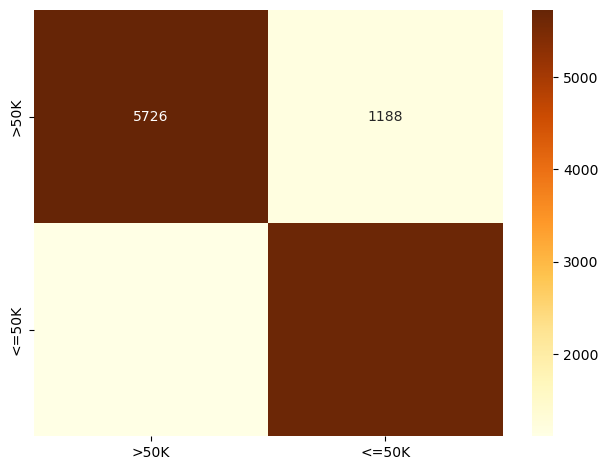

Test Матрица конфузии


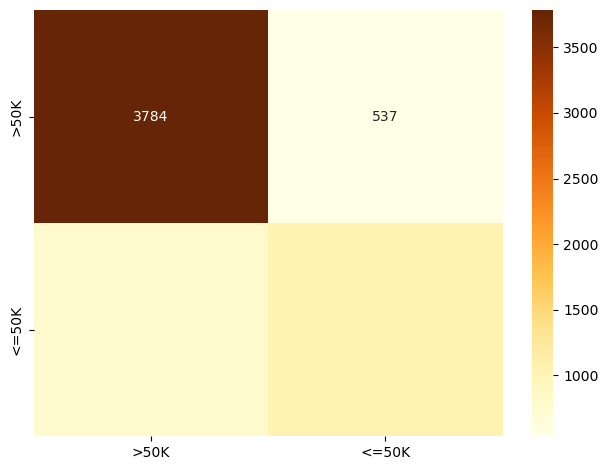

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

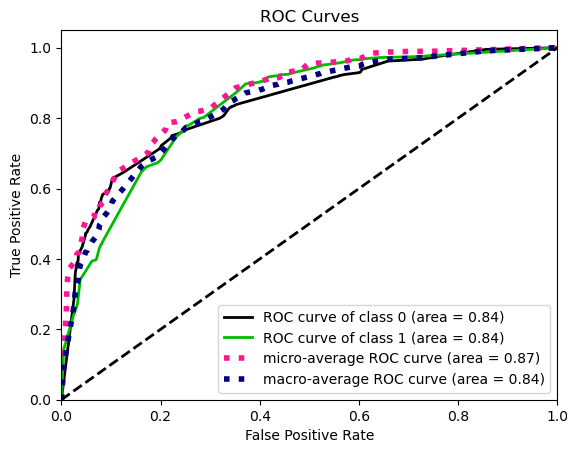

In [266]:
final_model = grid_search_dt_2.best_estimator_

print(skl.metrics.classification_report(y_test, final_model.predict(X_test)))

print(f'Train score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Val score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Test score {f1_score(final_model.predict(X_test),y_test)}')

plot_confusionmatrix(final_model.predict(X_train),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test),y_test,dom='Test')

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test))

#### Лучший Случайный лес

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4558
           1       0.68      0.71      0.70      1576

    accuracy                           0.84      6134
   macro avg       0.79      0.80      0.79      6134
weighted avg       0.84      0.84      0.84      6134

Train score 0.9421643141512849
Val score 0.9421643141512849
Test score 0.6964618249534451
Train Матрица конфузии


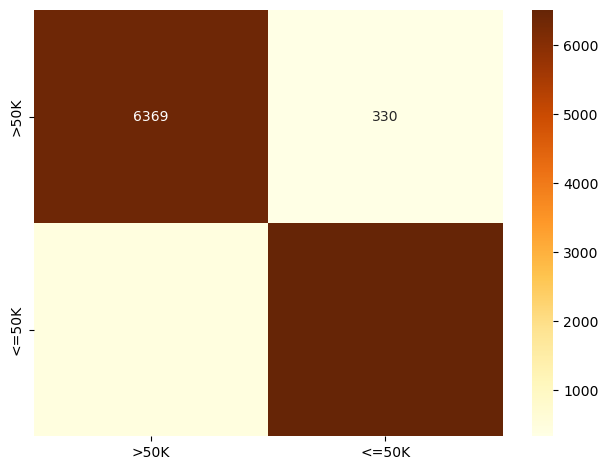

Test Матрица конфузии


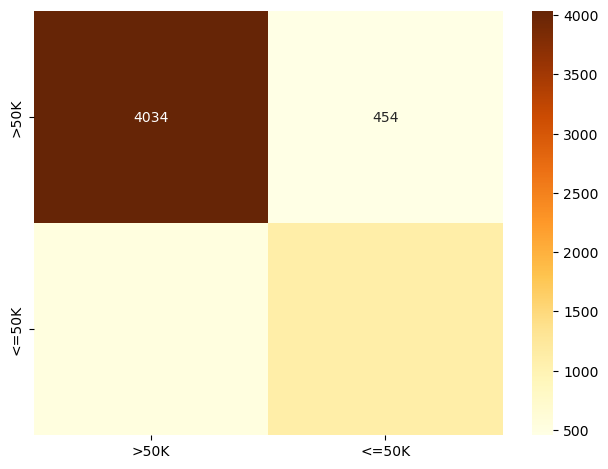

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

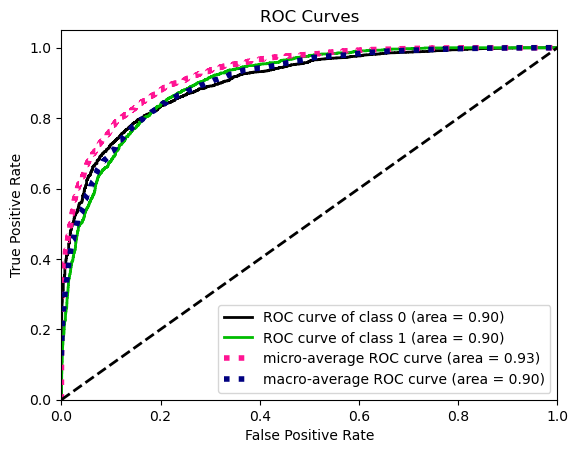

In [267]:
final_model = grid_search_rf_2.best_estimator_

print(skl.metrics.classification_report(y_test, final_model.predict(X_test)))

print(f'Train score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Val score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Test score {f1_score(final_model.predict(X_test),y_test)}')

plot_confusionmatrix(final_model.predict(X_train),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test),y_test,dom='Test')

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test))

#### CatBoost

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      4558
           1       0.73      0.69      0.71      1576

    accuracy                           0.85      6134
   macro avg       0.81      0.80      0.81      6134
weighted avg       0.85      0.85      0.85      6134

Train score 0.9357486136783735
Val score 0.9357486136783735
Test score 0.7095934959349594


Train Матрица конфузии


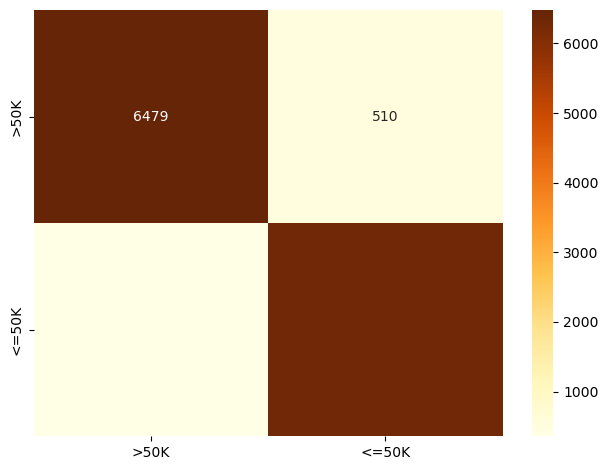

Test Матрица конфузии


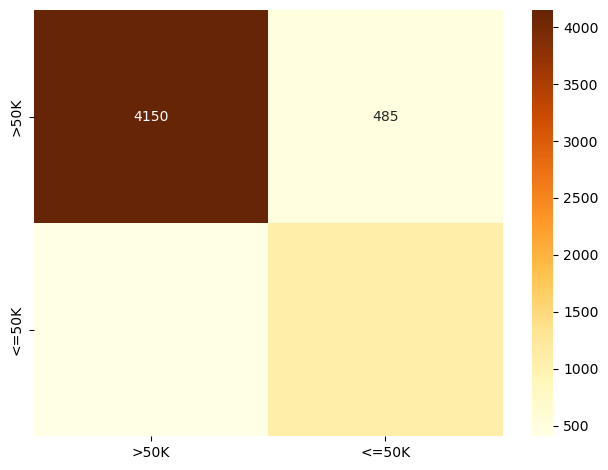

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

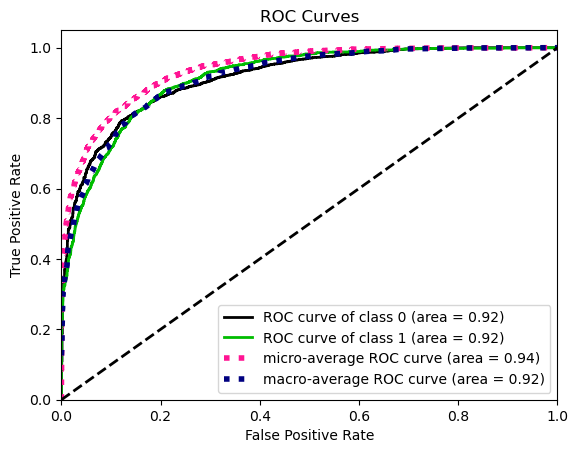

In [268]:
final_model = cb_basic

print(skl.metrics.classification_report(y_test, final_model.predict(X_test)))

print(f'Train score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Val score {f1_score(final_model.predict(X_train),y_train)}')
print(f'Test score {f1_score(final_model.predict(X_test),y_test)}')

plot_confusionmatrix(final_model.predict(X_train),y_train,dom='Train')
plot_confusionmatrix(final_model.predict(X_test),y_test,dom='Test')

skplt.metrics.plot_roc(y_test, final_model.predict_proba(X_test))

# Вывод



Получилось так, что Решающее дерево и Случайный лес совершают ошибки II рода на тестовой выборке. Это связано скорее всего с тем, что `SMOTE` трансформация неверно интерполировала данные для балансировки классов, а также с высокой размерностью датасета после `one-hot` кодировки. В свою очередь `CatBoost` на первоначальном датасете (до кодировки) выдал хороший результат.